In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# 读取 historicalCongestion.csv 文件
congestion_df = pd.read_csv("historicalCongestion.csv")

# 读取 testDataconarr.csv 文件
testDataConArr_df = pd.read_csv("testDataconarr.csv")

# 读取 trainingDataconarr.csv 文件
trainingDataConArr_df = pd.read_csv("trainingDataconarr.csv")

# 读取 testDatatimings.csv 文件
testDataTimings_df = pd.read_csv("testDatatimings.csv")

# 读取 trainingDatatimings.csv 文件
trainingDataTimings_df = pd.read_csv("trainingDatatimings.csv")

def drop_first_column(df):#删除第一列
  # 使用 `drop()` 方法删除列
  # axis=1 表示删除列
  # inplace=False 表示不修改原 DataFrame，而是返回新的 DataFrame
  return df.drop(df.columns[:1], axis=1, inplace=False)

'''
# congestion_df = drop_first_column(congestion_df)
# testDataConArr_df = drop_first_column(testDataConArr_df)
# trainingDataConArr_df = drop_first_column(trainingDataConArr_df)
# testDataTimings_df = drop_first_column(testDataTimings_df)
# trainingDataTimings_df = drop_first_column(trainingDataTimings_df)
#把train.code列的名字改一下，为后续匹配做准备
# trainingDataConArr_df = trainingDataConArr_df.rename(columns={'train_code':'train.code'})
# testDataConArr_df = testDataConArr_df.rename(columns={'train_code':'train.code'})
#按照train.code的值匹配联表
# trainingDataTimings_df = trainingDataTimings_df.merge(trainingDataConArr_df,on = 'train.code',how='left')
# 生成索引列，我也不知道为什么
# trainingDataConArr_df = trainingDataConArr_df.reset_index()
# testDataConArr_df = testDataConArr_df.reset_index()
# #将表格合并一下
# trainingDataTimings_df = trainingDataTimings_df.merge(trainingDataConArr_df, left_on='id', right_on='index', how='left').drop('index',axis=1)
# testDataTimings_df = testDataTimings_df.merge(testDataConArr_df, left_on='id', right_on='index', how='left').drop('index',axis=1)
'''


"\n# congestion_df = drop_first_column(congestion_df)\n# testDataConArr_df = drop_first_column(testDataConArr_df)\n# trainingDataConArr_df = drop_first_column(trainingDataConArr_df)\n# testDataTimings_df = drop_first_column(testDataTimings_df)\n# trainingDataTimings_df = drop_first_column(trainingDataTimings_df)\n#把train.code列的名字改一下，为后续匹配做准备\n# trainingDataConArr_df = trainingDataConArr_df.rename(columns={'train_code':'train.code'})\n# testDataConArr_df = testDataConArr_df.rename(columns={'train_code':'train.code'})\n#按照train.code的值匹配联表\n# trainingDataTimings_df = trainingDataTimings_df.merge(trainingDataConArr_df,on = 'train.code',how='left')\n# 生成索引列，我也不知道为什么\n# trainingDataConArr_df = trainingDataConArr_df.reset_index()\n# testDataConArr_df = testDataConArr_df.reset_index()\n# #将表格合并一下\n# trainingDataTimings_df = trainingDataTimings_df.merge(trainingDataConArr_df, left_on='id', right_on='index', how='left').drop('index',axis=1)\n# testDataTimings_df = testDataTimings_df.merge(testDa

In [2]:
# 转换时间用的
def text_to_seconds(text_time):
  """
  Converts a time string in HH:MM:SS format to seconds.

  Args:
      text_time: The time string to convert.

  Returns:
      The time in seconds as an integer.
  """

  # Split the time string into hours, minutes, and seconds
  hours, minutes, seconds = map(int, text_time.split(":"))

  # Convert each unit to seconds and sum them up
  return hours * 3600 + minutes * 60 + seconds


d:\Code\Anaconda\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.2`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  func(*plot_args, **plot_kwargs)
d:\Code\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Code\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Code\Anaconda\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.

<Figure size 10000x6000 with 0 Axes>

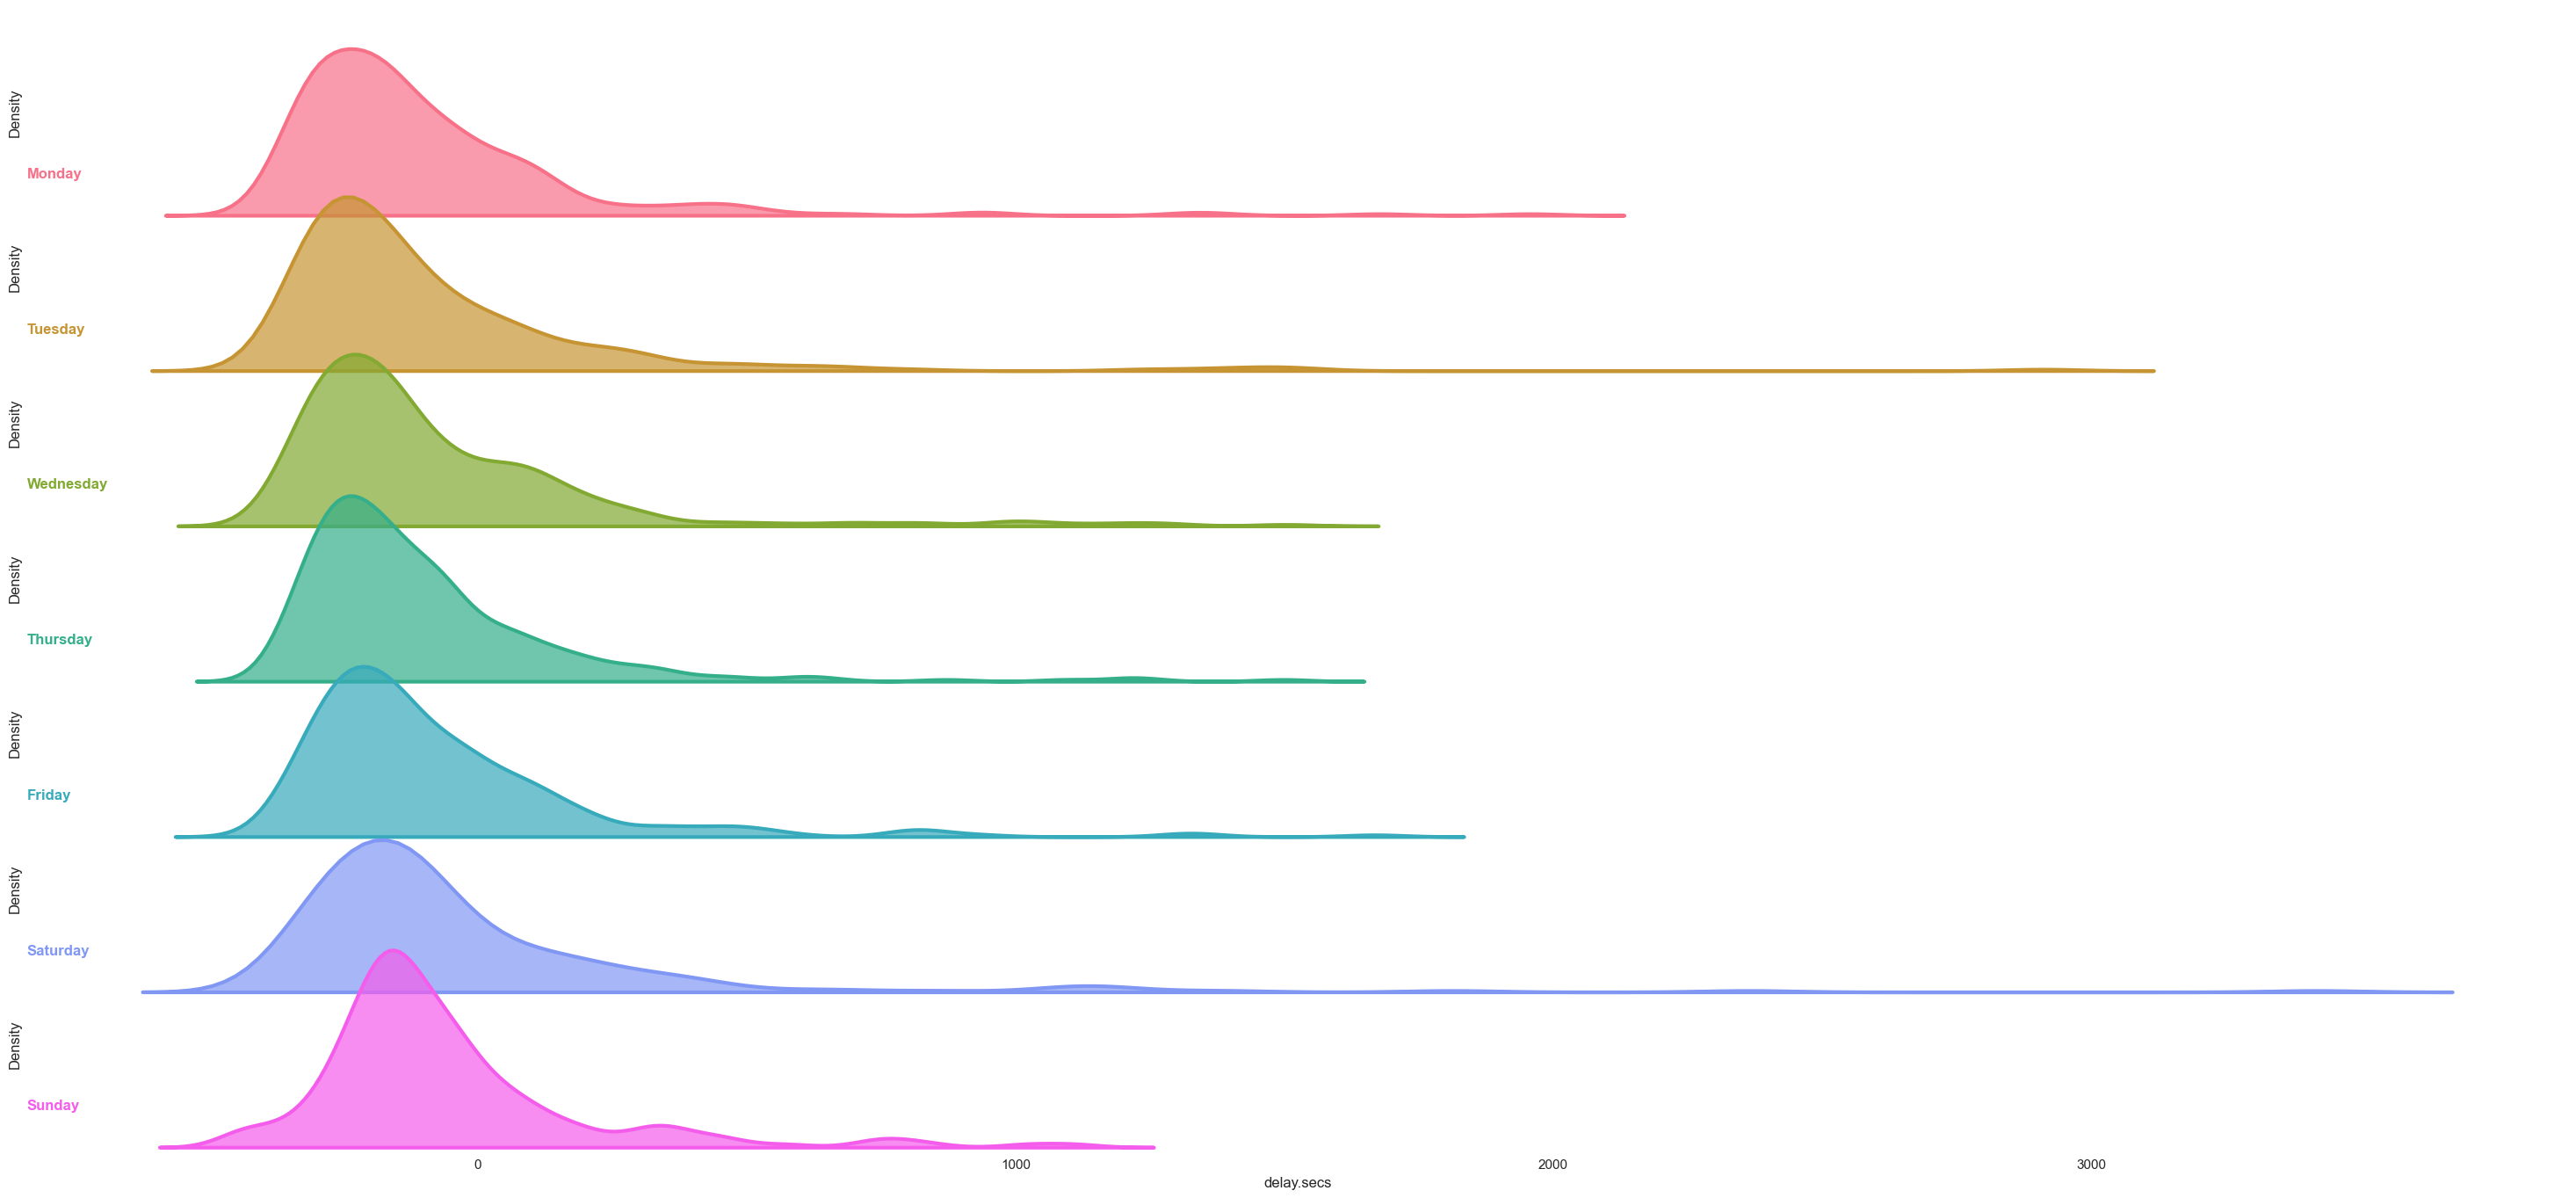

In [3]:
# 山脊图，根据周几来查看火车的延迟情况。
# 可以看出绝大部分情况下都是提前到的，但是在周二和周六下出现长时间延迟的可能会多一些，但也只是少数情况。
# 周日的演示情况反而会很少。可能是英国这边周日的车次会少很多，加上司机会想要早点回家。

# 定义周几的顺序
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 将'week.day'列转换为有序的类别类型
trainingDataConArr_df['week.day'] = pd.Categorical(trainingDataConArr_df['week.day'], categories=days_order, ordered=True)


# 使用seaborn的kdeplot来创建山脊图，首先我们需要设置图的风格
sns.set_theme(style="white",rc={"axes.facecolor":(0,0,0,0)})

# 创建一个画布
plt.figure(figsize=(100, 60))

# 创建一个颜色调色板
palette = sns.color_palette("husl", len(trainingDataConArr_df['week.day'].unique()))

# 使用FacetGrid和kdeplot绘制山脊图
g = sns.FacetGrid(trainingDataConArr_df, row='week.day', hue='week.day', aspect=15, height=2, palette=palette)

# 添加密度图，shade为True表示填充颜色
g.map(sns.kdeplot, 'delay.secs', clip_on=False, fill=True, alpha=0.7, lw=3, bw=.2)

# 使用白色分隔线增加每行之间的可读性
# g.map(plt.axhline, y=0, lw=2, clip_on=False)

# 定义和使用一个简单的函数来标签每个图的y轴
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "delay.secs")

# 设置图的属性，移除y轴的标签，添加标题等
g.fig.subplots_adjust(hspace=-.250)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

# 显示图表
plt.show()


In [4]:

# 统计 'train.code' 列中不同值的数量
# trainingDataConArr_df['train_code'].nunique()
# unique_train_codes_count_test = testDataConArr_df['train_code'].nunique()

# trainingDataTimings_df.columns#检查列名
# print(trainingDataTimings_df.columns)#检查列名
# congestion_df.columns
# print(trainingDataTimings_df.dtypes)#打印每列的数据类型

In [5]:
# #制作Scatterplot Matrix 散点图矩阵
# sns.set_theme(style="ticks")

# # trainingDataTimings_df = sns.load_dataset("penguins")
# sns.pairplot(trainingDataTimisngs_df, hue="day.week")

In [6]:
# 各种功能函数
#用于将一列的值转换为数值型特征的函数。
def encode_discrete_values(df, column_name):
    # 获取指定列的唯一值，并排序（如果是非数值型数据，将按字典序排序）
    unique_values = sorted(df[column_name].unique())
    
    # 生成从这些唯一值到 1~n 的映射字典
    value_to_num = {value: i + 1 for i, value in enumerate(unique_values)}
    
    # 检查列名是否在 DataFrame 中
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return None, None
    
    # 对指定列进行映射转换
    df[column_name + '_encoded'] = df[column_name].map(value_to_num)
    
    # 返回更新后的 DataFrame 和映射字典
    return df, value_to_num

# 使用示例
# df, mapping_dict = encode_discrete_values(df, 'your_column_name')

# 用于将周几转换为数值型
def encode_weekdays(df, column_name):
    # 定义星期几到数字的映射字典
    weekday_to_num = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7,
    }
    
    # 检查列名是否在 DataFrame 中
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return None, None
    
    # 对指定列进行映射转换
    df[column_name + '_encoded'] = df[column_name].map(weekday_to_num)
    
    # 返回更新后的 DataFrame 和映射字典
    return df, weekday_to_num

# 你可以像这样调用这个函数：
# df, mapping_dict = encode_weekdays(df, 'your_column_name')
# 转换车站
def encode_common_discrete_values(df, columns):
    # 获取两列所有唯一值的并集，并排序
    # unique_values = sorted(set(df[columns[0]].unique()).union(set(df[columns[1]].unique())))
    value_to_num = {
        'LEEDS': 1,
        'NORMNTN':2,
        'WKFLDKG':3,
        'WKFLDWG':4,
        'BNSLY':5,
        'MEADWHL':6,
        'SHEFFLD':7,
    }
    # 生成映射字典
    # value_to_num = {value: i + 1 for i, value in enumerate(unique_values)}
    
    # 对指定的两列进行映射转换
    for column in columns:
        if column not in df.columns:
            print(f"Column '{column}' not found in DataFrame.")
            continue
        df[column + '_encoded'] = df[column].map(value_to_num)
    
    # 返回更新后的 DataFrame 和映射字典
    return df, value_to_num

# 使用示例
# df, mapping_dict = encode_common_discrete_values(df, ['column1_name', 'column2_name'])

# 计算时间差值
def calculate_time_difference(df, column1, column2, new_column_name='time_difference'):
    """
    Calculates the difference in seconds between two time columns in HH:MM:SS format and adds it as a new column.
    
    Args:
        df: The DataFrame containing the time columns.
        column1: The name of the first time column.
        column2: The name of the second time column.
        new_column_name: The name of the new column to add with the time difference (in seconds).
        
    Returns:
        The DataFrame with the added column showing the time difference in seconds.
    """
    
    # Ensure the columns exist in the DataFrame
    if column1 not in df.columns or column2 not in df.columns:
        raise ValueError(f"One or both of the specified columns '{column1}', '{column2}' do not exist in the DataFrame.")
    
    # Apply the text_to_seconds function to each time column
    seconds1 = df[column1].apply(text_to_seconds)
    seconds2 = df[column2].apply(text_to_seconds)
    
    # Calculate the difference and add it as a new column
    df[new_column_name] = (seconds1 - seconds2)#.abs()  # Use .abs() to ensure the difference is non-negative
    
    return df

# 使用示例
# 假设你有一个 DataFrame `df`，其中包含两列时间字符串 'start_time' 和 'end_time'
# df = calculate_time_difference(df, 'start_time', 'end_time', 'duration_seconds')




In [7]:
#对于小站的处理：先使用0和1代表是否经过这一站（存在性编码），然后使用平均值代表这些站的总平均延误（聚合）
# 还是之前的问题，我需要在处理数据的前后都进行数据分析
def datapreprcession(targetdatatimings = trainingDataTimings_df,dataconarr= trainingDataConArr_df,historicalcon=congestion_df):
    #等后续把之前写的内容全部放到这里来
    #先先出第一列多出来的unmaned列
    matrixdata =drop_first_column(targetdatatimings)
    dataconarr = drop_first_column(dataconarr)
    historicalcon = drop_first_column(historicalcon)
    #重置index列
    dataconarr = dataconarr.reset_index()
    #合并表格
    matrixdata = matrixdata.merge(dataconarr, left_on='id', right_on='index', how='left').drop('index',axis=1)
    #合并历史延误
    matrixdata = matrixdata.merge(historicalcon,left_on=['week.day', 'hour'],right_on=['Day','Hour'],how='left')
    #删除一列重复的列
    matrixdata = matrixdata.drop(['day.week','week.day','hour','train_code','arrival.to_y'],axis=1)
    # 将一列的值转换为数值型特征
    matrixdata, traincode_to_num = encode_discrete_values(matrixdata,column_name='train.code')
    # print(traincode_to_num)
    # 按顺序转换周几为数值型特征
    matrixdata, day_to_num = encode_weekdays(matrixdata,column_name='Day')
    # 将车站转换为数值型特征
    matrixdata,station_to_num=encode_common_discrete_values(matrixdata,['departure.from','arrival.to_x'])
    # print(station_to_num)
    # 计算时间差值
    matrixdata = calculate_time_difference(matrixdata,column1='departure.time',column2='departure.schedule',new_column_name='departure.delay')
    matrixdata = calculate_time_difference(matrixdata,column1='arrival.time_x',column2='arrival.schedule_x',new_column_name='arrival.delay')
    return matrixdata
#应用预处理，得到目标可以训练的数据
trainmatrix = datapreprcession(targetdatatimings=trainingDataTimings_df,dataconarr=trainingDataConArr_df,historicalcon=congestion_df)
testmatrix = datapreprcession(targetdatatimings=testDataTimings_df,dataconarr=testDataConArr_df,historicalcon=congestion_df)



In [8]:
print(trainmatrix['departure.from'].unique())
print(trainmatrix['arrival.to_x'].unique())
print(trainmatrix.columns)
print(trainmatrix.head(10))
# trainmatrix.to_csv('trainmatrix.csv',index=False)

['LEEDS' 'WKFLDKG' 'BNSLY' 'MEADWHL' 'NORMNTN' 'WKFLDWG']
['WKFLDKG' 'BNSLY' 'MEADWHL' 'SHEFFLD' 'NORMNTN' 'WKFLDWG']
Index(['train.code', 'departure.from', 'departure.time', 'departure.schedule',
       'arrival.to_x', 'arrival.time_x', 'arrival.schedule_x', 'id',
       'Leeds.trains_x', 'Leeds.av.delay_x', 'Sheffield.trains_x',
       'Sheffield.av.delay_x', 'Nottingham.trains_x', 'Nottingham.av.delay_x',
       'arrival.time_y', 'arrival.schedule_y', 'delay.secs', 'Day', 'Hour',
       'Leeds.trains_y', 'Leeds.av.delay_y', 'Sheffield.trains_y',
       'Sheffield.av.delay_y', 'Nottingham.trains_y', 'Nottingham.av.delay_y',
       'train.code_encoded', 'Day_encoded', 'departure.from_encoded',
       'arrival.to_x_encoded', 'departure.delay', 'arrival.delay'],
      dtype='object')
  train.code departure.from departure.time departure.schedule arrival.to_x  \
0       1Y09          LEEDS       07:05:38           07:05:00      WKFLDKG   
1       1Y09        WKFLDKG       07:25:16        

d:\Code\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Code\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


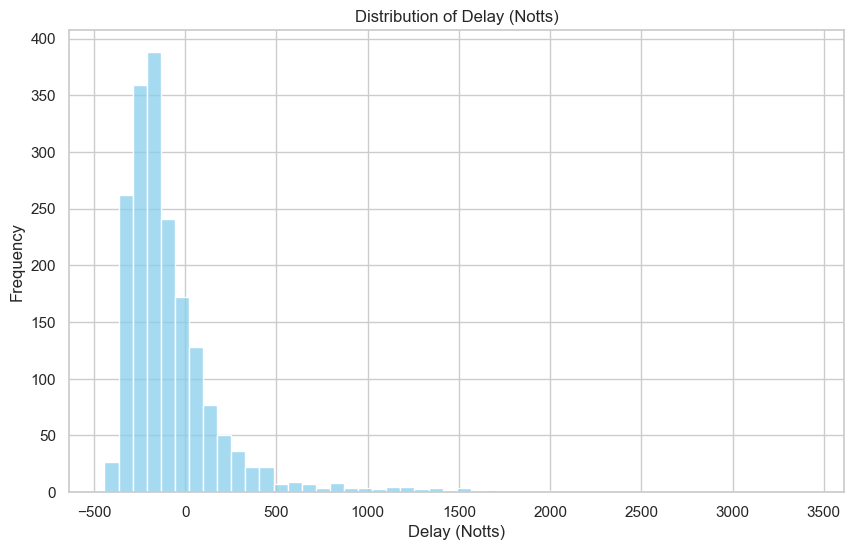

In [9]:
#绘制delayNotts的柱状分布
# 设置绘图风格
sns.set_style("whitegrid")

# 绘制柱状分布图（直方图）
plt.figure(figsize=(10, 6))  # 设置图形的大小
sns.histplot(trainingDataConArr_df['delay.secs'], bins=50, kde=False, color='skyblue')  # bins指定直方图的柱数，kde为是否绘制核密度估计

plt.title('Distribution of Delay (Notts)')  # 设置图形标题
plt.xlabel('Delay (Notts)')  # 设置x轴标签
plt.ylabel('Frequency')  # 设置y轴标签
plt.show()

In [16]:
#做图函数
#制作数值型列的山脊图
'''
def plot_ridge(df, selected_columns):
    """
    Plots a ridge plot for selected columns of a DataFrame.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - selected_columns (list of str): List of column names to plot the ridge plot for.
    """
    # Ensure that selected_columns is a list
    if not isinstance(selected_columns, list):
        raise ValueError("selected_columns must be a list of column names.")
    
    # Melt the dataframe to long format for selected columns
    melted_df = df[selected_columns].melt(var_name='Variable', value_name='Value')

    # Set up the FacetGrid
    g = sns.FacetGrid(melted_df, row='Variable', hue='Variable', aspect=15, height=0.5, palette="tab20")

    # Map the densities to the FacetGrid
    g.map(sns.kdeplot, 'Value', bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, 'Value', clip_on=False, color="w", lw=2, bw_adjust=0.5)
    
    # Overlap each row
    g.fig.subplots_adjust(hspace=-0.3)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.fig.suptitle('Ridge Plot of Selected Variables')
    plt.subplots_adjust(top=0.95)

# Example usage:
# Assuming `restructured_data` is your DataFrame
# selected_columns = ['column1', 'column2']  # Replace with your actual column names
# plot_ridge(restructured_data, selected_columns)
'''

#制作二元变量列的柱状统计图，未使用
def plot_bar_for_binary_columns(df, target_columns):
    """
    This function plots bar plots for given binary columns in a DataFrame.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_columns (list of str): List of binary column names to be plotted.
    """
    # 设置绘图风格
    sns.set_style("whitegrid")
    
    # 确定子图的布局
    num_cols = len(target_columns)
    if num_cols == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
        axes = [axes]
    else:
        fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(6, 4 * num_cols))
    
    for i, col in enumerate(target_columns):
        # 计算每个类别的计数
        count_data = df[col].value_counts().sort_index()
        # 绘制柱状图
        sns.barplot(x=count_data.index, y=count_data.values, ax=axes[i], palette="viridis")
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel(col)
    
    plt.tight_layout()
    plt.show()

# 示例使用方法
# 假设 df 是你的 DataFrame，'binary_col1' 和 'binary_col2' 是二元变量列名
# plot_bar_for_binary_columns(df, ['binary_col1', 'binary_col2'])

#二元变量列，带上他们的统计个数
def plot_bar_for_binary_columns_with_counts(df, target_columns):
    """
    This function plots bar plots for given binary columns in a DataFrame and
    annotates each bar with its count.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_columns (list of str): List of binary column names to be plotted.
    """
    # 设置绘图风格
    sns.set_style("whitegrid")
    
    # 确定子图的布局
    num_cols = len(target_columns)
    if num_cols == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
        axes = [axes]
    else:
        fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(6, 4 * num_cols))
    
    for i, col in enumerate(target_columns):
        # 计算每个类别的计数
        count_data = df[col].value_counts().sort_index()
        # 绘制柱状图
        ax = sns.barplot(x=count_data.index, y=count_data.values, ax=axes[i], palette="viridis")
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel(col)

        # 在柱子上方显示计数
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

    plt.tight_layout()
    plt.show()

# 示例使用方法
# 假设 df 是你的 DataFrame，'binary_col1' 和 'binary_col2' 是二元变量列名
# plot_bar_for_binary_columns_with_counts(df, ['binary_col1', 'binary_col2'])


#分类列和目标列的分布关系
def plot_violin_by_group(df, group_column, target_column):

    plt.figure(figsize=(10, 6))
    sns.violinplot(x=group_column, y=target_column, data=df)
    plt.title(f'Distribution of {target_column} by {group_column}')
    plt.xlabel(group_column)
    plt.ylabel(target_column)
    plt.show()
# plot_violin_by_group(df, 'Group', 'Value')


# 分类列和目标列的分布关系
def plot_density_by_group(df, group_column, target_column):
    """
    Plots density plots of a target column distribution within each group defined by another column.

    Args:
    - df (pd.DataFrame): The input DataFrame.
    - group_column (str): The name of the column to group by.
    - target_column (str): The name of the column for which to plot the density distribution.
    """
    plt.figure(figsize=(10, 6))
    
    # 为每个分组绘制密度图
    unique_groups = df[group_column].unique()
    for group in unique_groups:
        subset = df[df[group_column] == group]
        sns.kdeplot(subset[target_column], label=f'{group}', shade=True)
    
    plt.title(f'Density Distribution of {target_column} by {group_column}')
    plt.xlabel(target_column)
    plt.ylabel('Density')
    plt.legend(title=group_column)
    plt.show()

# plot_density_by_group(df, 'Group', 'Value')



In [11]:
# 考虑到最好还是一行代表一个数据点，关键分只在于不能将conarr表扩散到matrixdata里
'''
def rebuild_matrixdata(df):

    # 这是车站与其对应顺序的映射字典
    stations_order = {
        'LEEDS': 1,
        'NORMNTN': 2,
        'WKFLDKG': 3,
        'WKFLDWG': 4,  # 注意这个站名出现了两次，我会假设第二个应为唯一的
        'BNSLY': 5,
        'MEADWHL': 6,
        'SHEFFLD': 7,
        # 'WKFLDWG': 8,  # 重复的站点，已注释
    }

    # 假设df是原始的DataFrame
    # 确保你已经加载了原始的DataFrame
    # df = pd.read_csv('/path/to/csv')

    # 创建一个空的DataFrame，用于存储重构后的数据
    restructured_data = pd.DataFrame()

    # 遍历每个ID，并构建重构后的数据
    for id_val, group in df.groupby('id'):
        new_row = {}
        # 标记每个车站的出现
        station_presence = {station: 0 for station in stations_order}
        # 遍历每个车站，检查它是否在每个ID的路线上
        for station in stations_order:
            # 初始化时间和计划列
            new_row[f"{station}_time"] = None
            new_row[f"{station}_schedule"] = None
            # 检查出发点
            dep_rows = group[group['departure.from'] == station]
            if not dep_rows.empty:
                # 设置存在性编码
                station_presence[station] = 1
                # 获取时间和计划
                new_row[f"{station}_time"] = dep_rows['departure.time'].iloc[0]
                new_row[f"{station}_schedule"] = dep_rows['departure.schedule'].iloc[0]
            # 检查到达点
            arr_rows = group[group['arrival.to'] == station]
            if not arr_rows.empty:
                # 设置存在性编码
                station_presence[station] = 1
                # 如果出发时间已经设置了，那么我们更新为到达时间
                if pd.isna(new_row[f"{station}_time"]):
                    new_row[f"{station}_time"] = arr_rows['arrival.time'].iloc[0]
                # 同理更新计划时间
                if pd.isna(new_row[f"{station}_schedule"]):
                    new_row[f"{station}_schedule"] = arr_rows['arrival.schedule'].iloc[0]
        # 合并存在性编码
        new_row = {**new_row, **station_presence}
        # 将新行添加到重构数据中
        # restructured_data = restructured_data.append(new_row, ignore_index=True)
        restructured_data = pd.concat([restructured_data, pd.DataFrame([new_row])], ignore_index=True)


    # 设置新的列顺序，包括时间、计划和存在性编码
    columns_order = []
    for station in stations_order:
        columns_order.extend([f"{station}_time", f"{station}_schedule", f"{station}_presence"])

    restructured_data = restructured_data[columns_order]
    restructured_data['id'] = restructured_data.index  # 添加ID列

    # 显示结果
    print(restructured_data.head())

    # 保存到新的 CSV 文件中
    # restructured_data.to_csv('restructured_data.csv', index=False)

    return restructured_data
'''

'''
def rebuild_matrixdata(df):
    # Station order mapping
    stations_order = {
        'LEEDS': 1,
        'NORMNTN': 2,
        'WKFLDKG': 3,
        'WKFLDWG': 4,  # Assuming this is a unique station
        'BNSLY': 5,
        'MEADWHL': 6,
        'SHEFFLD': 7
    }
    
    rows_list = []  # This list will accumulate all the rows before adding them to DataFrame
    
    # Process each train ID
    for train_id in df['id'].unique():
        train_data = df[df['id'] == train_id]
        row_data = {f"{station}_{suffix}": None for station in stations_order for suffix in ['time', 'schedule']}
        row_data.update({f"{station}_presence": 0 for station in stations_order})
        
        for station in stations_order:
            # Check departure information
            if station in train_data['departure.from'].values:
                row = train_data[train_data['departure.from'] == station].iloc[0]
                row_data[f"{station}_time"] = row['departure.time']
                row_data[f"{station}_schedule"] = row['departure.schedule']
                row_data[f"{station}_presence"] = 1
            
            # Check arrival information
            if station in train_data['arrival.to'].values:
                row = train_data[train_data['arrival.to'] == station].iloc[0]
                row_data[f"{station}_time"] = row_data[f"{station}_time"] or row['arrival.time']
                row_data[f"{station}_schedule"] = row_data[f"{station}_schedule"] or row['arrival.schedule']
                row_data[f"{station}_presence"] = 1
        
        rows_list.append(row_data)
    
    # Convert the list of dictionaries to a DataFrame
    restructured_data = pd.DataFrame(rows_list)
    
    # Set the train ID as the index of the new DataFrame
    restructured_data['id'] = df['id'].unique()
    restructured_data.set_index('id', inplace=True)
    
    return restructured_data
'''

def rebuild_matrixdata(df):
    stations_order = [
        'LEEDS', 'NORMNTN', 'WKFLDKG', 'WKFLDWG', 'BNSLY', 'MEADWHL', 'SHEFFLD'
    ]
    
    # 准备新的DataFrame结构
    new_columns = []
    for station in stations_order:
        if station not in ['LEEDS', 'SHEFFLD']:  # 对于LEEDS和SHEFFLD不需要存在性编码
            new_columns.append(f"{station}_presence")
        new_columns.extend([
            f"{station}_dep_time", f"{station}_dep_schedule",
            f"{station}_arr_time", f"{station}_arr_schedule"
        ])
        
    restructured_data_list = []

    for train_id in df['id'].unique():
        train_data = df[df['id'] == train_id]
        row_data = {col: None for col in new_columns}
        
        for station in stations_order:
            # 处理存在性编码
            if station not in ['LEEDS', 'SHEFFLD']:
                row_data[f"{station}_presence"] = int(station in train_data['departure.from'].values or station in train_data['arrival.to'].values)
            
            # 处理出发时间和计划
            dep_station_data = train_data[train_data['departure.from'] == station]
            if not dep_station_data.empty:
                row_data[f"{station}_dep_time"] = dep_station_data.iloc[0]['departure.time']
                row_data[f"{station}_dep_schedule"] = dep_station_data.iloc[0]['departure.schedule']
            
            # 处理到达时间和计划
            arr_station_data = train_data[train_data['arrival.to'] == station]
            if not arr_station_data.empty:
                row_data[f"{station}_arr_time"] = arr_station_data.iloc[0]['arrival.time']
                row_data[f"{station}_arr_schedule"] = arr_station_data.iloc[0]['arrival.schedule']
                
        restructured_data_list.append(row_data)
    
    restructured_data = pd.DataFrame(restructured_data_list)
    restructured_data['id'] = df['id'].unique()
    restructured_data.set_index('id', inplace=True)

    #鉴于后续统一操作，这drop建议之后再用
    # restructured_data = restructured_data.drop(['LEEDS_arr_time','LEEDS_arr_schedule','SHEFFLD_dep_time','SHEFFLD_dep_schedule'],axis=1)
    
    return restructured_data

# 用于将rebuild后的车站情况使用读秒函数将其变为秒
def calculate_delays_and_stays(df):
    # 遍历DataFrame的每一行
    for index, row in df.iterrows():
        for col in df.columns:
            if '_dep_time' in col or '_arr_time' in col:
                station = col.split('_')[0]
                time_type = 'dep' if 'dep' in col else 'arr'  # 确定是出发时间还是到达时间

                # 构造时间和计划时间的列名
                actual_col = f'{station}_{time_type}_time'
                schedule_col = f'{station}_{time_type}_schedule'
                
                # 计算延误时间
                if pd.notna(row[actual_col]) and pd.notna(row[schedule_col]):
                    actual_seconds = text_to_seconds(row[actual_col])
                    schedule_seconds = text_to_seconds(row[schedule_col])
                    df.at[index, f'{station}_{time_type}_delay'] = actual_seconds - schedule_seconds

            # 对于中间站，计算停留时间和计划停留时间
            if '_dep_time' in col and station != 'LEEDS' and station != 'SHEFFLD':
                arr_col = f'{station}_arr_time'
                dep_col = f'{station}_dep_time'
                arr_schedule_col = f'{station}_arr_schedule'
                dep_schedule_col = f'{station}_dep_schedule'

                # 计算实际停留时间和计划停留时间，假设时间和计划时间都存在
                if pd.notna(row[arr_col]) and pd.notna(row[dep_col]) and pd.notna(row[arr_schedule_col]) and pd.notna(row[dep_schedule_col]):
                    arr_seconds = text_to_seconds(row[arr_col])
                    dep_seconds = text_to_seconds(row[dep_col])
                    arr_schedule_seconds = text_to_seconds(row[arr_schedule_col])
                    dep_schedule_seconds = text_to_seconds(row[dep_schedule_col])
                    
                    df.at[index, f'{station}_stay'] = dep_seconds - arr_seconds
                    df.at[index, f'{station}_scheduled_stay'] = dep_schedule_seconds - arr_schedule_seconds

    return df


# 输出所有数值型列的小提琴图
def plot_violin_for_numerical_columns(df):
    """
    This function takes a DataFrame and plots violin plots for all numerical columns.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.

    Output:
    - Displays violin plots for each numerical column in the DataFrame.
    """
    # Determine numerical columns by dtype
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Set up the matplotlib figure (adjust figsize as needed)
    fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(8, len(numerical_cols) * 4))
    
    # If only one numerical column, axes might not be an array, so we ensure it's always treated as one
    if len(numerical_cols) == 1:
        axes = [axes]
    
    # Plot violin plot for each numerical column
    for i, col in enumerate(numerical_cols):
        sns.violinplot(x=df[col], ax=axes[i],fill= False)
        axes[i].set_title(col)
        axes[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

# Assuming `restructured_data` is the DataFrame you want to use
# plot_violin_for_numerical_columns(restructured_data)

#数值型小提琴图，合成一张图
"""
def plot_violin_all_numerical_in_one(df):
    '''
    This function takes a DataFrame, melts it to long format for all numerical columns,
    and then plots violin plots for these columns all in one figure.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.

    Output:
    - A single figure with violin plots for each numerical column.
    '''
    # Select only numerical columns
    numerical_df = df.select_dtypes(include=['float64', 'int64'])

    # Melt the DataFrame
    melted_df = numerical_df.melt(value_vars=numerical_df.columns)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='variable', y='value', data=melted_df)
    plt.xticks(rotation=45)  # Rotate the x labels for better readability
    plt.xlabel('Variables')
    plt.ylabel('Values')
    plt.title('Violin plot for all numerical columns')
    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()

# Assuming `restructured_data` is your DataFrame:
# plot_violin_all_numerical_in_one(restructured_data) 
"""

#基于rebuild_matrixdata函数的新预处理步骤
def datapreprcession2(targetdatatimings = trainingDataTimings_df,dataconarr= trainingDataConArr_df,historicalcon=congestion_df):
    #等后续把之前写的内容全部放到这里来
    #先先出第一列多出来的unmaned列
    datatimings =drop_first_column(targetdatatimings)
    # print(datatimings.head())
    dataconarr = drop_first_column(dataconarr)
    historicalcon = drop_first_column(historicalcon)
    #重置index列
    dataconarr = dataconarr.reset_index()

    #关键两步
    # 重建特征集，每一行代表一辆火车
    matrixdata =rebuild_matrixdata(datatimings)
    #统计delay和stay等特征工程
    matrixdata = calculate_delays_and_stays(matrixdata)

    #合并表格
    matrixdata = matrixdata.merge(dataconarr, left_on='id', right_on='index', how='left').drop('index',axis=1)
    #合并历史延误
    matrixdata = matrixdata.merge(historicalcon,left_on=['week.day', 'hour'],right_on=['Day','Hour'],how='left')
    #删除重复的几列,不删除也可以，等到最后直接从其中提取
    matrixdata = matrixdata.drop(['week.day','hour'],axis=1)
    # 将train.code转换为数值型特征
    # matrixdata, traincode_to_num = encode_discrete_values(matrixdata,column_name='train_code')
    # 另一种将train.code转换为数值型特征的办法：uniques是唯一真值对照表
    codes, uniques = pd.factorize(matrixdata['train_code'])
    matrixdata['train_code.code'] = codes
    # 将周几转换为onehot特征
    matrixdata = pd.get_dummies(matrixdata, columns=['Day'])
    
    return matrixdata

C:\Users\SunWeiyi\AppData\Local\Temp\ipykernel_24340\1236015380.py:150: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[target_column], label=f'{group}', shade=True)
d:\Code\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Code\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SunWeiyi\AppData\Local\Temp\ipykernel_24340\1236015380.py:150: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.

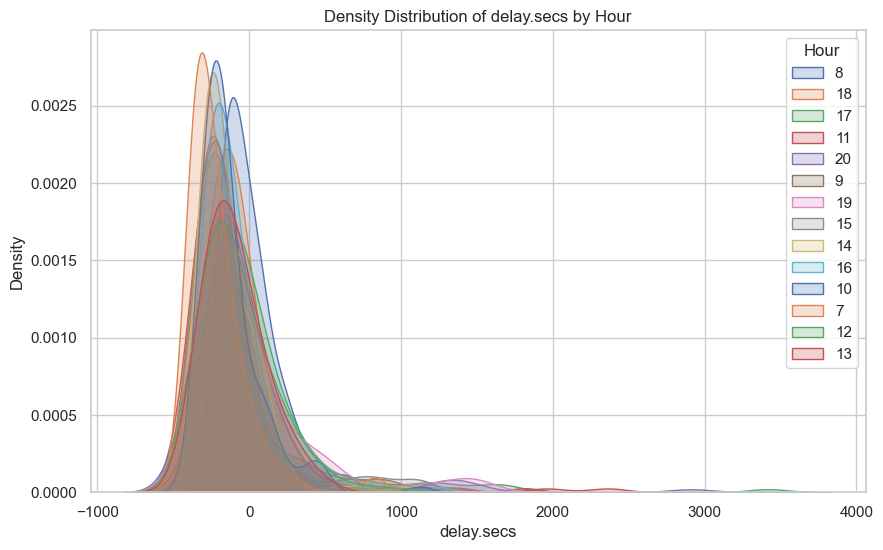

In [17]:
#下面是推荐的pipeline的代码框架
def process_features(df):
    #TBD 之后还会修改成只选取一部分列作为特征集，而不是使用drop
    df = df.drop(['train.code', 'departure.from', 'departure.time', 'departure.schedule',
       'arrival.to_x', 'arrival.time_x','arrival.schedule_x','arrival.time_y', 'arrival.schedule_y','Day'],axis=1)
    return df


# 获取特征和目标变量
def get_features_and_target(df, target_column_name):
    X = df.drop(target_column_name, axis=1)
    y = df[target_column_name]
    return X, y

# 创建pipeline
def create_pipeline():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # 数据标准化
        ('regressor', XGBRegressor(objective='reg:squarederror'))  # XGBoost 回归器
    ])
    return pipeline

# 设置网格搜索的参数
params = {
    'regressor__max_depth': [3, 5, 7, 9],
    'regressor__n_estimators': [30, 50, 100, 200],
    'regressor__learning_rate': [0.01, 0.1]
}

# 主函数
def main():
    # 加载数据
    # df = load_data('path/to/your/dataset.csv')

    #执行预处理
    trainmatrix = datapreprcession(targetdatatimings=trainingDataTimings_df,dataconarr=trainingDataConArr_df,historicalcon=congestion_df)
    # trainmatrix2 = datapreprcession2(targetdatatimings=trainingDataTimings_df,dataconarr=trainingDataConArr_df,historicalcon=congestion_df)
    # testmatrix = datapreprcession(targetdatatimings=testDataTimings_df,dataconarr=testDataConArr_df,historicalcon=congestion_df)    

    # 先删去无法使用的特征列
    trainmatrix = process_features(trainmatrix)
    # print(trainmatrix.columns)
    
    # 获取特征和目标变量
    X, y = get_features_and_target(trainmatrix, 'delay.secs')
    
    # 创建pipeline
    pipeline = create_pipeline()
    
    # 创建GridSearchCV对象
    # grid_search = GridSearchCV(pipeline, param_grid=params, cv=8, scoring='neg_mean_squared_error', verbose=1)
    
    # # 执行网格搜索
    # grid_search.fit(X, y)
    
    # # 打印最佳参数和最佳分数（MSE）
    # print(f"Best parameters: {grid_search.best_params_}")
    # print(f"Best cross-validation score (MSE): {-grid_search.best_score_}")

if __name__ == "__main__":
    main()
    trainmatrix2 = datapreprcession2(targetdatatimings=trainingDataTimings_df,dataconarr=trainingDataConArr_df,historicalcon=congestion_df)
    # plot_density_by_group(trainmatrix2,group_column='Hour',target_column='delay.secs')

In [13]:
print(trainmatrix2.columns)
selected_columns = ['LEEDS_dep_delay', 'WKFLDKG_dep_delay', 'WKFLDKG_stay',
       'WKFLDKG_scheduled_stay', 'WKFLDKG_arr_delay', 'BNSLY_dep_delay',
       'BNSLY_stay', 'BNSLY_scheduled_stay', 'BNSLY_arr_delay',
       'MEADWHL_dep_delay', 'MEADWHL_stay', 'MEADWHL_scheduled_stay',
       'MEADWHL_arr_delay', 'SHEFFLD_arr_delay', 'NORMNTN_dep_delay',
       'NORMNTN_stay', 'NORMNTN_scheduled_stay', 'NORMNTN_arr_delay',
       'WKFLDWG_dep_delay', 'WKFLDWG_stay', 'WKFLDWG_scheduled_stay',
       'WKFLDWG_arr_delay']  # Replace with your actual column names
selected_columns2 = ['WKFLDKG_presence','NORMNTN_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence']
# plot_ridge(trainmatrix3, selected_columns)
# plot_violin_for_numerical_columns(trainmatrix3)
# plot_bar_for_binary_columns_with_counts(trainmatrix3,selected_columns2)